In [110]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
Sys.setenv(RETICULATE_PYTHON="/home/welison/.conda/envs/decontX_reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/welison/.conda/envs/decontX_reticulate/bin/python")
reticulate::use_condaenv("/home/welison/.conda/envs/decontX_reticulate")
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [111]:
#is you get messages that any of these packages aren't installed
#go ahead and locally install them yourself using install.packages()

#library(GenomeInfoDb,lib.loc="/nfs/lab/welison/multiome_practice/lib/")

suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
#install.packages('harmony')
suppressMessages(library(harmony))
suppressMessages(library(data.table))
#suppressMessages(library(ggpubr))
library(gridExtra)
warnLevel <- getOption('warn')
options(warn = -1)
library(BPCells)
library(stringr)
library(leidenbase)

In [3]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/welison/.conda/envs/mamba/envs/seurat5.0_decontx/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] leidenbase_0.1.27         stringr_1.5.1            
 [3] BPCells_0.1.0             gridExtra_2.3            
 [5] data.table_1.15.2         harmony_1.2.0            
 [7] Rcpp_1.0.1

# Read in ATAC and RNA

Made merged fragment file 10.18.21, took around 1 hour

In [99]:
# Set some values and load sample list
dataset <- 'nPOD'
modality <- 'Pooled'

#rds_dir <- paste0("/nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/DoubFind_adatas/')
#your pipeline stops at decontx outputs not doublet finder outputs
#looking at script 241125_AH_nPOD_Single_Sample_Processing_Pool.ipynb 
rds_dir <- paste0("/nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/", dataset,"/231121_WE_SSP_Intermediates/DecontX_adatas/")
window_dir <- paste0("/nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/ATAC_Windows/')

samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")

samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]

samples

gc()

[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   13836101  739.0   28989488  1548.3   28989488  1548.3
Vcells 1237616298 9442.3 2815260314 21478.8 2815249670 21478.7

#  Filter by demuxlet 

In [100]:
#read in the RDS files
#wipe out the ATAC and SCT componenets
adatas <- list()
for (samp in samples){
    
    #Read in RDS
    adata <- readRDS(paste0(rds_dir, samp,"_",modality,".RDS"))
    adatas[[samp]] <- adata
    adata <- NULL
    
    #Clean Up the Object
    DefaultAssay(adatas[[samp]]) <- 'RNA'
    adatas[[samp]]$RNA.raw <- NULL 
   # adatas[[samp]]$ATAC <- NULL   
    
    demux <- read.table(paste0("/nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231121_WE_SSP_Intermediates/demux_out/", samp, ".best"), sep='\t', header=T)
    demux_sub <- demux[str_detect(demux$DROPLET.TYPE, "SNG"),]
    demux_sub$donor_id <-gsub("_.*","",demux_sub$BEST.GUESS)
    demux_sub_filt <- demux_sub[demux_sub$BARCODE %in% colnames(adatas[[samp]]),]

    ### Add donor metadata under column 'donor_demux'
    multiome_filtered <- adatas[[samp]][,colnames(adatas[[samp]]) %in% demux_sub_filt$BARCODE]
    rownames(demux_sub_filt) <- demux_sub_filt[,2]
    filtered_df <- demux_sub_filt$donor_id

    multiome_filtered <- AddMetaData(
      object = multiome_filtered,
      metadata = filtered_df,
      col.name = 'donor_demux'
    )
    adatas[[samp]] = multiome_filtered
    
}

adatas
#adatas[1]

$MM_1349_1_2_MM_1345_1_2
An object of class Seurat 
185784 features across 4958 samples within 2 assays 
Active assay: RNA (36601 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

$MM_1350_1_2_MM_1346_1_2
An object of class Seurat 
185797 features across 4335 samples within 2 assays 
Active assay: RNA (36601 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

$MM_1351_1_2_MM_1347_1_2
An object of class Seurat 
173532 features across 3769 samples within 2 assays 
Active assay: RNA (36601 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 5 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn

$MM_1352_1_2_MM_1348_1_2
An object of class Seurat 


# Merge

In [ ]:
adata <- merge(adatas[[1]], adatas[-1], add.cell.ids=samples, project=paste0(dataset, '_', modality))

adata
gc()

In [55]:
adata$RNA$counts

  [[ suppressing 32 column names 'MM_1349_1_2_MM_1345_1_2_AAACAGCCACAAAGAC-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCAGTCTATG-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCATCAATCG-1' ... ]]

  [[ suppressing 32 column names 'MM_1349_1_2_MM_1345_1_2_AAACAGCCACAAAGAC-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCAGTCTATG-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCATCAATCG-1' ... ]]

  [[ suppressing 32 column names 'MM_1349_1_2_MM_1345_1_2_AAACAGCCACAAAGAC-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCAGTCTATG-1', 'MM_1349_1_2_MM_1345_1_2_AAACAGCCATCAATCG-1' ... ]]



36601 x 78799 sparse Matrix of class "dgCMatrix"
                                                                                            
MIR1302-2HG   . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
FAM138A       . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
OR4F5         . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL627309.1    . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL627309.3    . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL627309.2    . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL627309.5    . . . .  .  . .  2  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL627309.4    . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AP006222.2    . . . .  .  . .  .  . .  . . .  .  .  . .  . .  . .  . .  . . .  . . . .  .  .
AL732372.1    . . . .

In [ ]:
saveRDS(adata, paste0("/nfs/lab/welison/mega_pancreas/intermediates/Intermediate_Merge_Data/250328_AH_", dataset,"_", modality,"_hvw_window_adata.RDS"))

# Remove Samples

samples nPOD-6228 nPOD-6236 were removed in QC
it appears there were 36 to start and 34 final 
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  nPOD-6228_nPOD-6228     nPOD-6236_nPOD-6236     nPOD-6301_nPOD-6301     nPOD-6303_nPOD-6303       nPOD-6314_nPOD-6314     nPOD-6347_nPOD-6347     nPOD-6392_nPOD-6392     nPOD-6397_nPOD-6397     nPOD-6400_nPOD-6400     nPOD-6424_nPOD-6424       nPOD-6483_nPOD-6483     6232_6232       6421_6421       6474_6474       6494_6494       6504_6504       6509_6509       6516_6516 6517_6517       6532_6532       HDL011_HDL011   HDL112_HDL112   10_nPOD_6433_4_5_23     11_nPOD_6437_4_10_23    12_nPOD_6455_4_10_23    14_nPOD_6496_4_10_23      15_nPOD_6538_4_10_23    16_nPOD_6539_4_10_23    17_nPOD_6543_4_10_23    18_nPOD_6548_4_10_23    19_nPOD_6553_4_10_23    20_nPOD_6558_4_10_23      21_nPOD_6560_4_10_23    22_nPOD_6562_4_10_23    23_nPOD_6569_4_10_23    24_nPOD_CV02_4_10_23

In [60]:
#adata_sub <- subset(
#      x = adata,
#      subset = Sample %in% keep
#)

#adata_sub

# Perform analyses and clustering

In [ ]:
marker.genes <- c('INS','PDX1','GCG','ARX',  #Beta (2) and alpha (2)
                 'SST','PPY', #Delta (1) and Gamma (1)
                 'VWF','PLVAP','CDH5', #Endothelial
                 'REG1A','CTRB2','PRSS1', #Acinar
                 'CFTR','ANXA9','AQP1', #Ductal
                 'C1QC','C1QB','C1QA', #Macrophages
                 'CD69', 'CD19', 'CD4','CD8A',#Immune & B Cells
                 'CXCR4','GATA3','CD3D', #T Cells
                 'PDGFRB','SPARC','COL6A3', 'COL1A1',#Stellate, COL1A1 is activated
                 'MKI67', 'LYVE1', 'CDH19', 'PMP22') #cycling, lymph endo,schwann 2x

## RNA

In [ ]:
# RNA Clustering

RNA_assay='RNA' 
res=0.5

DefaultAssay(adata) <- RNA_assay
adata <- NormalizeData(adata) %>%
            FindVariableFeatures() %>%
            ScaleData() %>%
            RunPCA() %>% 
            RunHarmony(group.by.vars='donor_demux', reduction='pca', assay.use=RNA_assay, 
                               reduction.save='harmony.rna') %>%
            RunUMAP(dims=1:50, reduction='harmony.rna',
                    reduction.name=paste0('umap.', str_to_lower(RNA_assay)), 
                    reduction.key=paste0(str_to_lower(RNA_assay),'UMAP_'))

adata <- FindNeighbors(adata, assay=RNA_assay, reduction='harmony.rna', dims=1:50, verbose = FALSE)
adata <- FindClusters(adata, algorithm=4, verbose=FALSE, resolution=res,  method='igraph')

adata

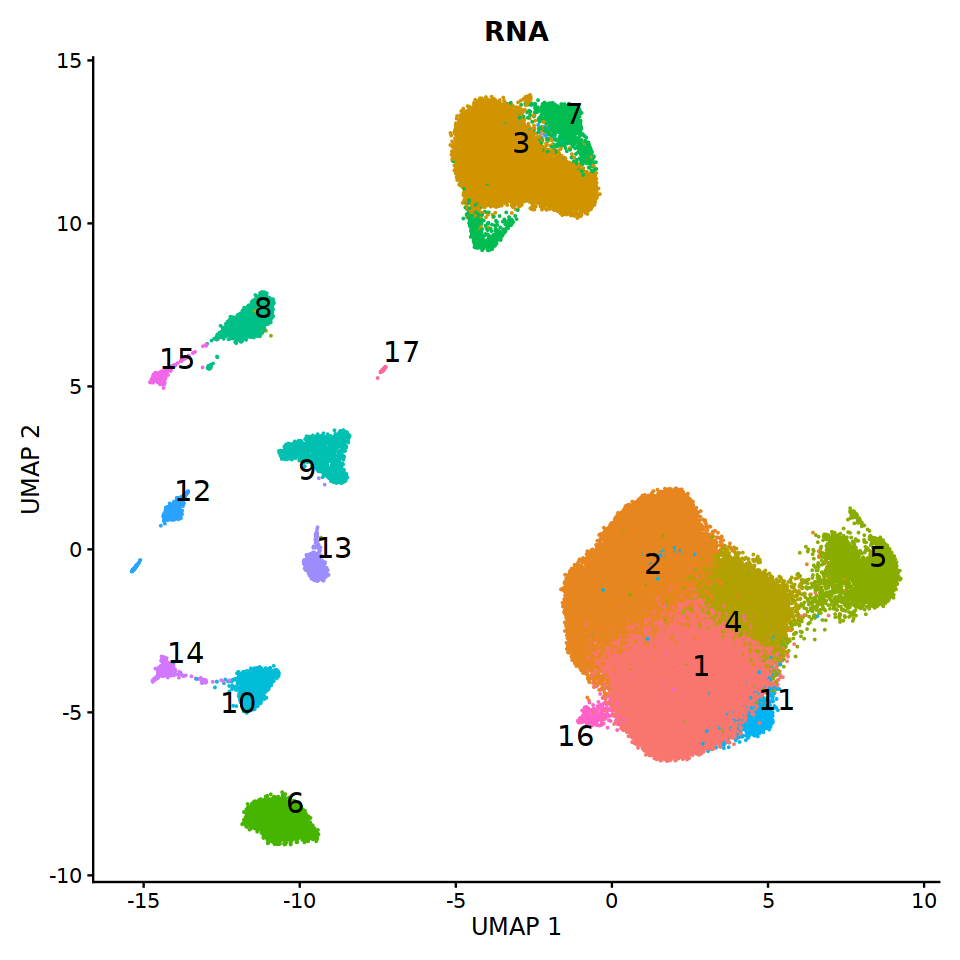

In [65]:
options(repr.plot.width=8, repr.plot.height=8)
p1 <- DimPlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE)
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0(RNA_assay))
p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
p1

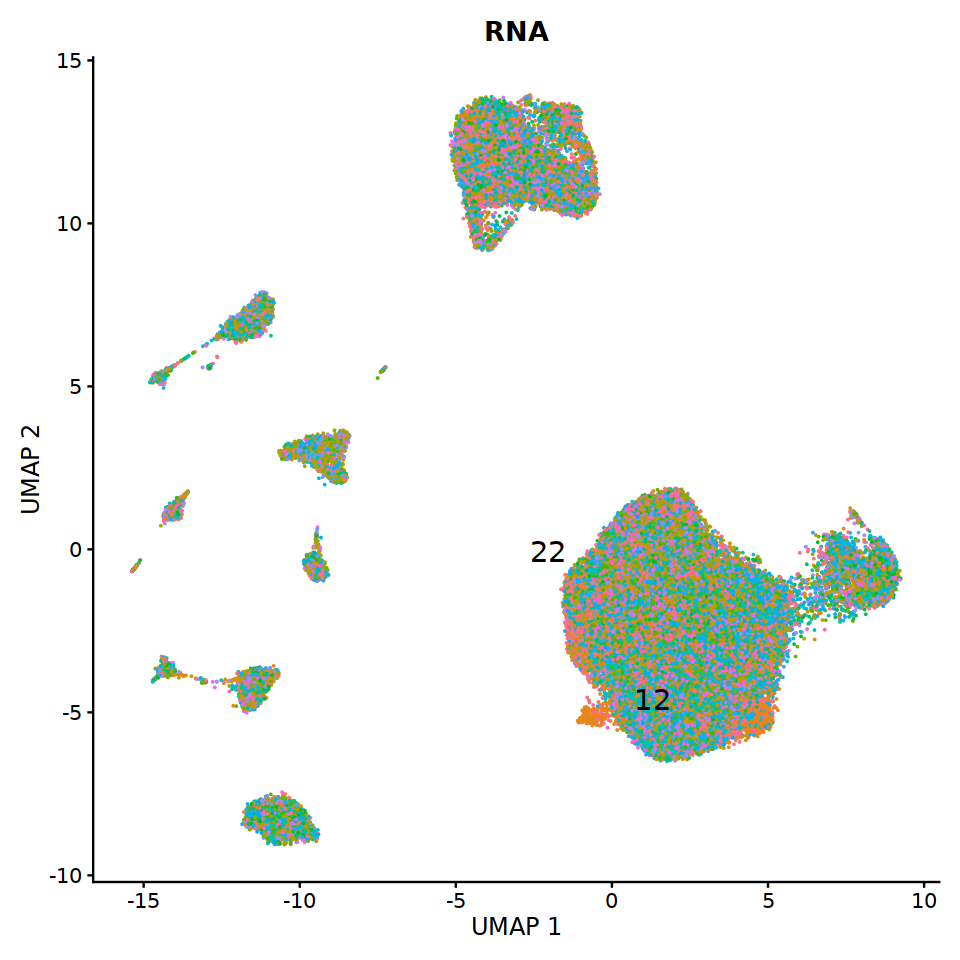

In [67]:
options(repr.plot.width=8, repr.plot.height=8)
p1 <- DimPlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), group.by='donor_demux', label=TRUE, label.size=6, repel=TRUE)
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0(RNA_assay))
p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
p1

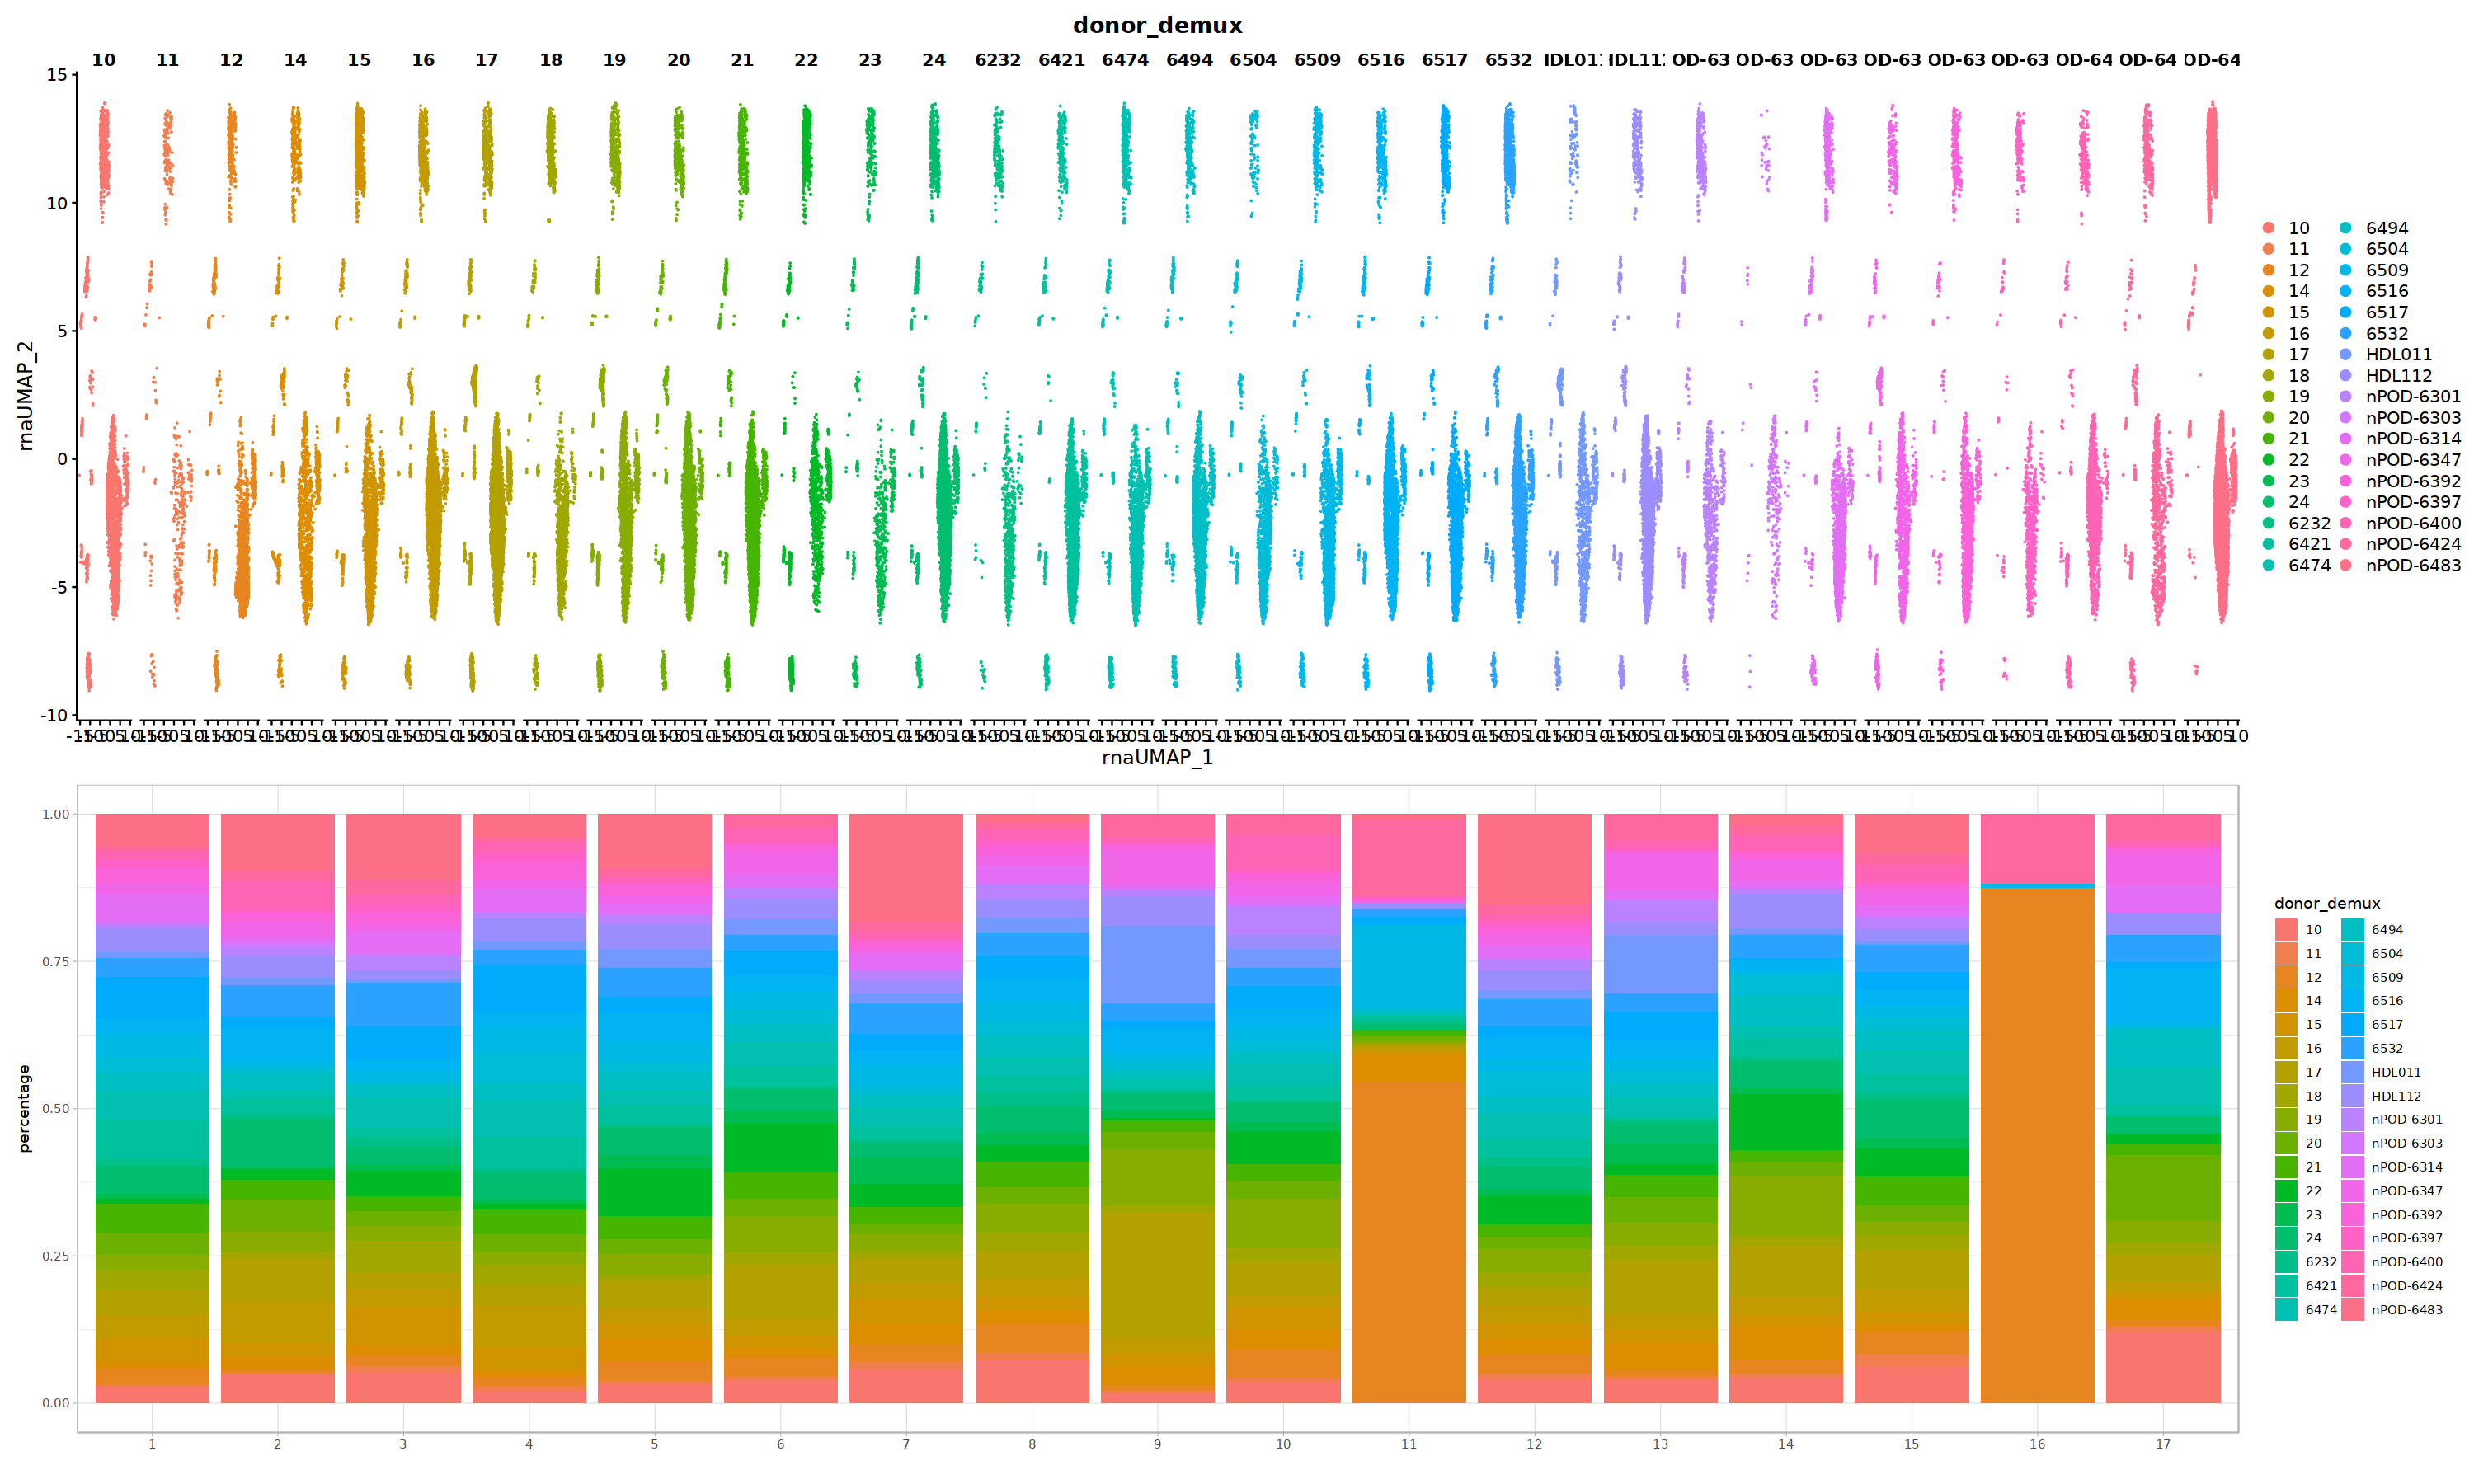

In [70]:
options(repr.plot.width=25, repr.plot.height=15)
p1 <- DimPlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), group.by='donor_demux', split.by='donor_demux', label=FALSE, label.size=6, repel=TRUE)
adata$value <- 1
p2 <- ggplot(adata[[]], aes(fill=donor_demux, y=value, x=seurat_clusters)) + geom_bar(position=position_fill(reverse=TRUE), stat='identity') + xlab('') + ylab('percentage') + theme_light()
p1 / p2

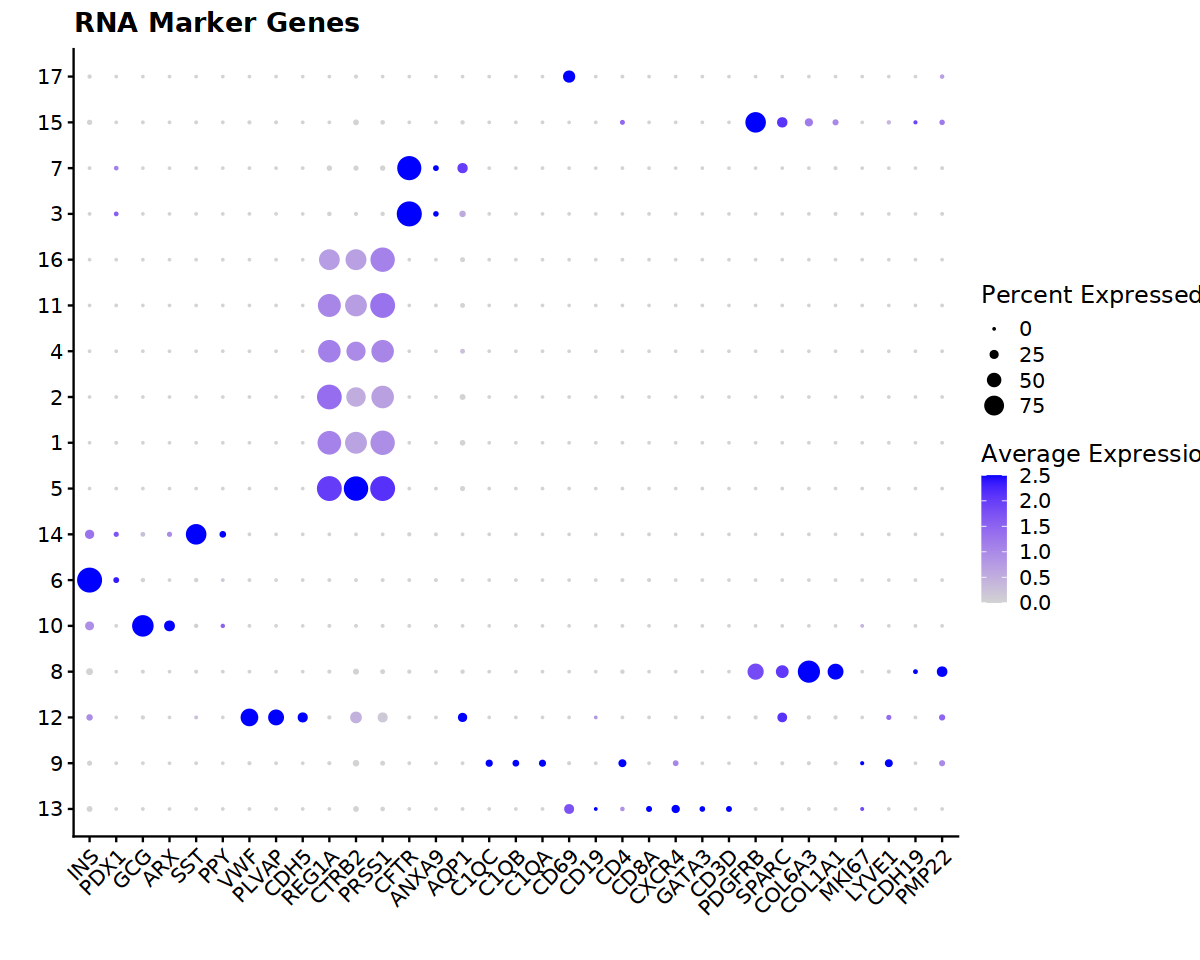

In [72]:
options(repr.plot.width=10, repr.plot.height=8)
p1 <- DotPlot(adata, assay=RNA_assay, features=marker.genes, cluster.idents=TRUE, col.min=0) 
p1 <- p1 + theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('') + ggtitle(paste0('RNA Marker Genes'))
p1

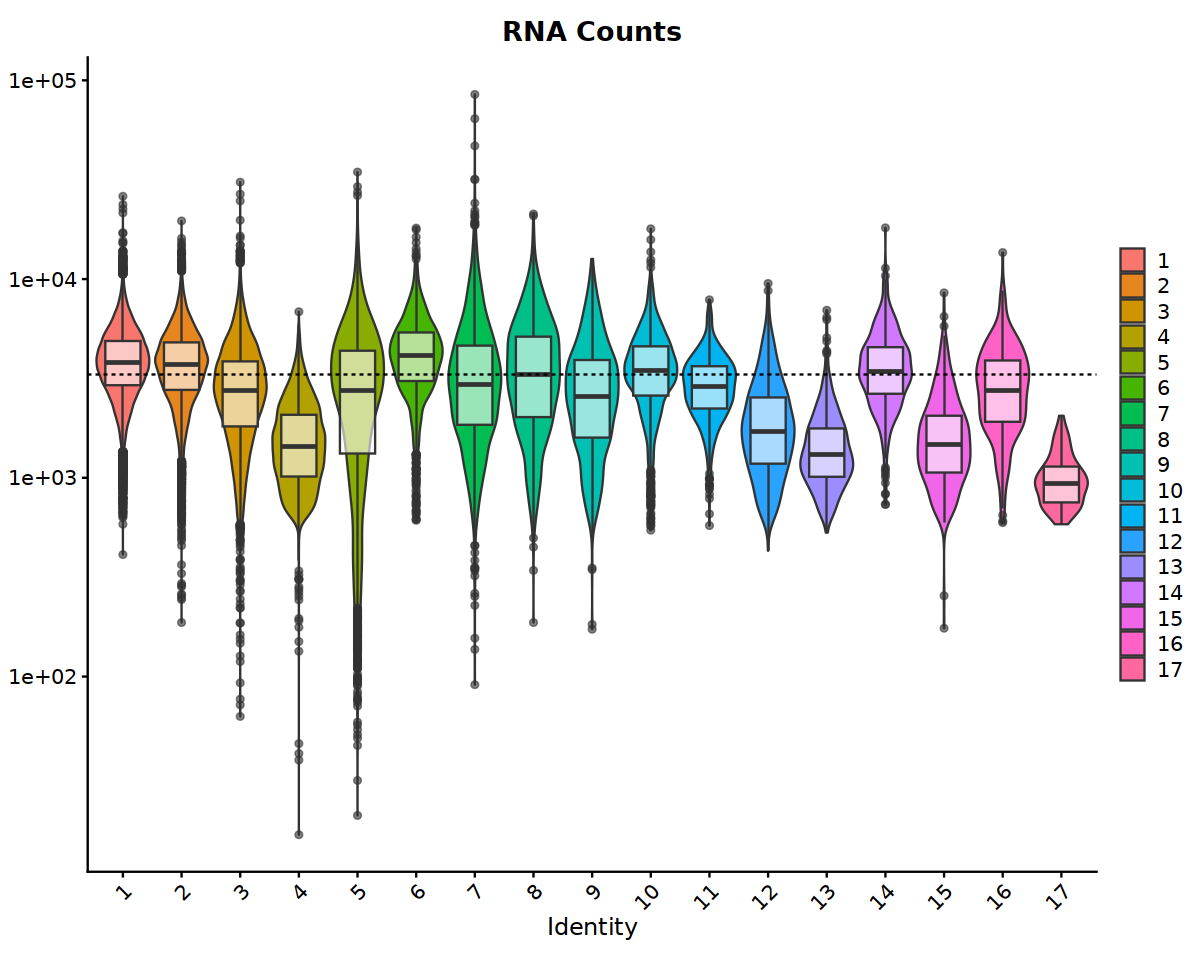

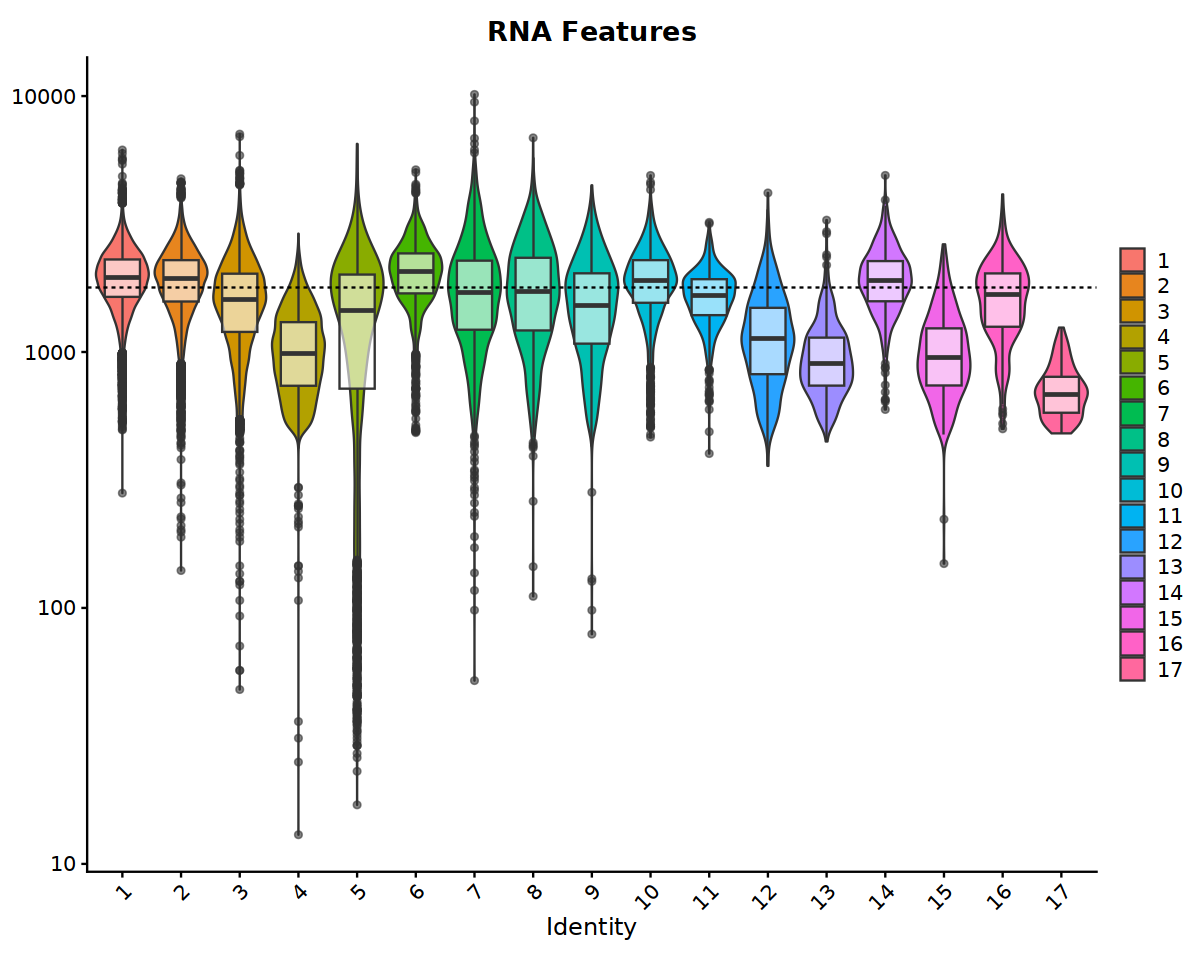

In [73]:
options(repr.plot.width=10, repr.plot.height=8)
p1 <- VlnPlot(adata, features=paste0('nCount_', RNA_assay), group.by='seurat_clusters', pt.size=0, log=TRUE) + 
    geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
    geom_hline(yintercept=median(unlist(adata[[paste0('nCount_', RNA_assay)]])), linetype='dashed', lw=2) + 
    ggtitle(paste0(RNA_assay,' Counts'))
p2 <- VlnPlot(adata, features=paste0('nFeature_', RNA_assay), group.by='seurat_clusters', pt.size=0, log=TRUE) + 
    geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
    geom_hline(yintercept=median(unlist(adata[[paste0('nFeature_', RNA_assay)]])), linetype='dashed', lw=2) + 
    ggtitle(paste0(RNA_assay,' Features'))
p1
p2

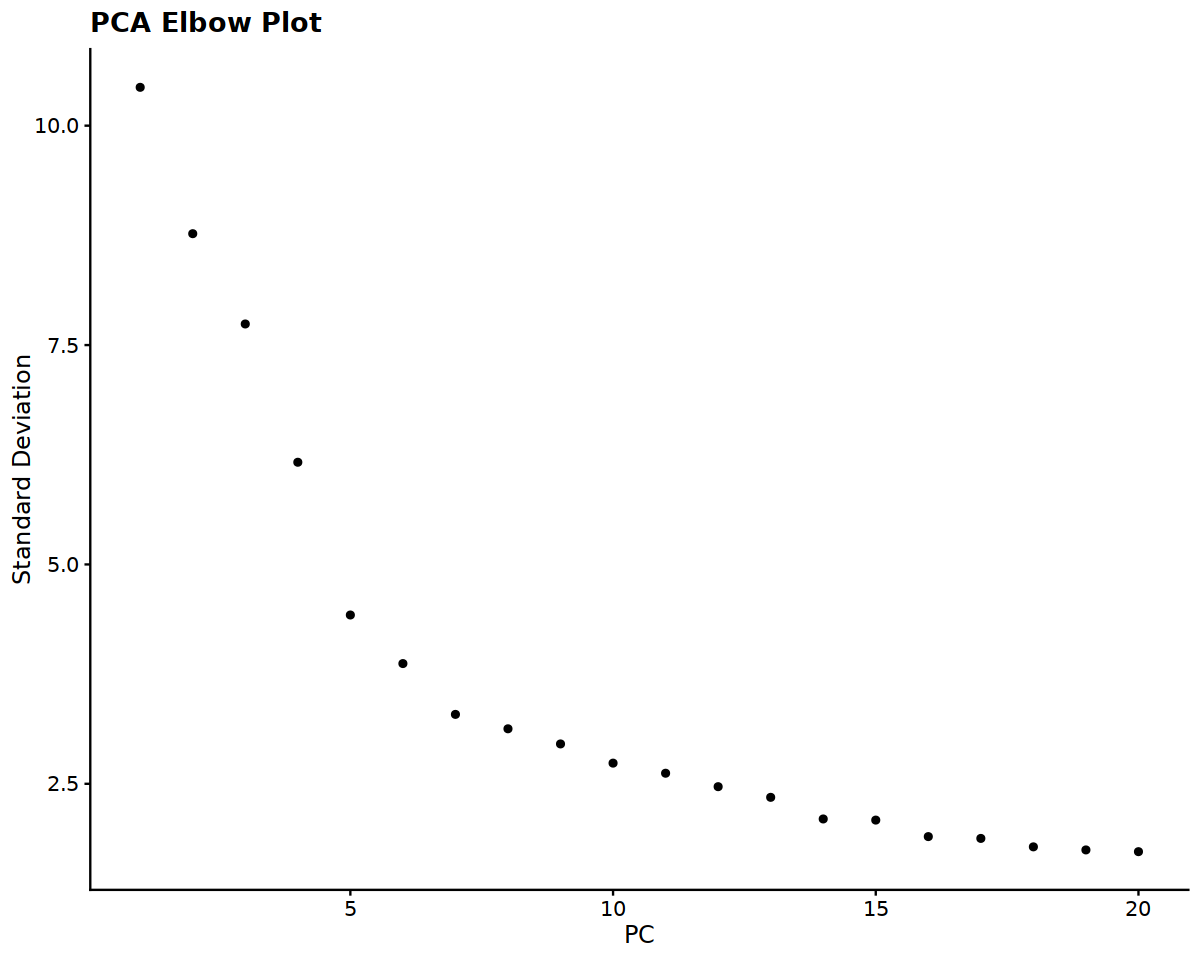

In [74]:
options(repr.plot.width=10, repr.plot.height=8)
ElbowPlot(adata, reduction='pca') + ggtitle(paste0('PCA Elbow Plot'))

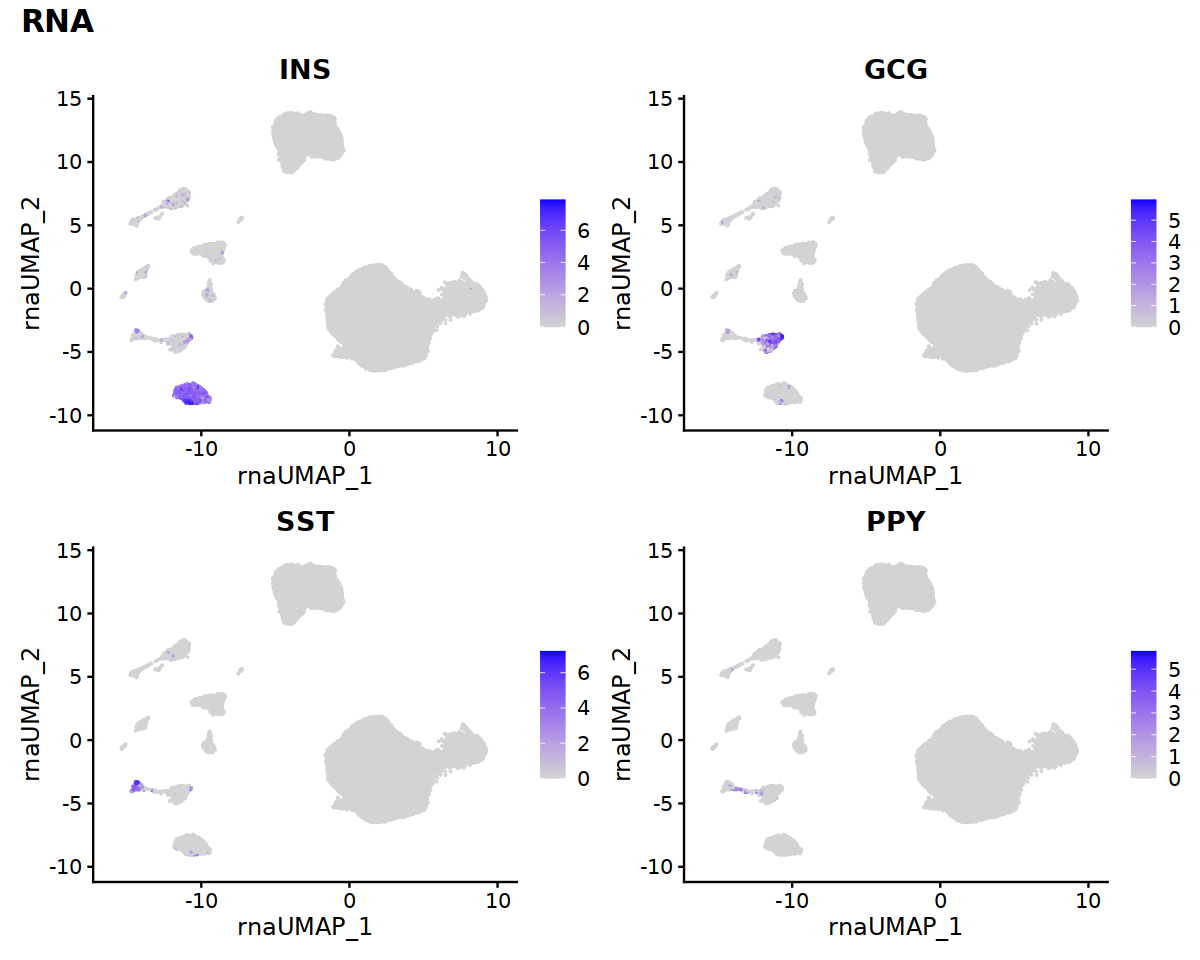

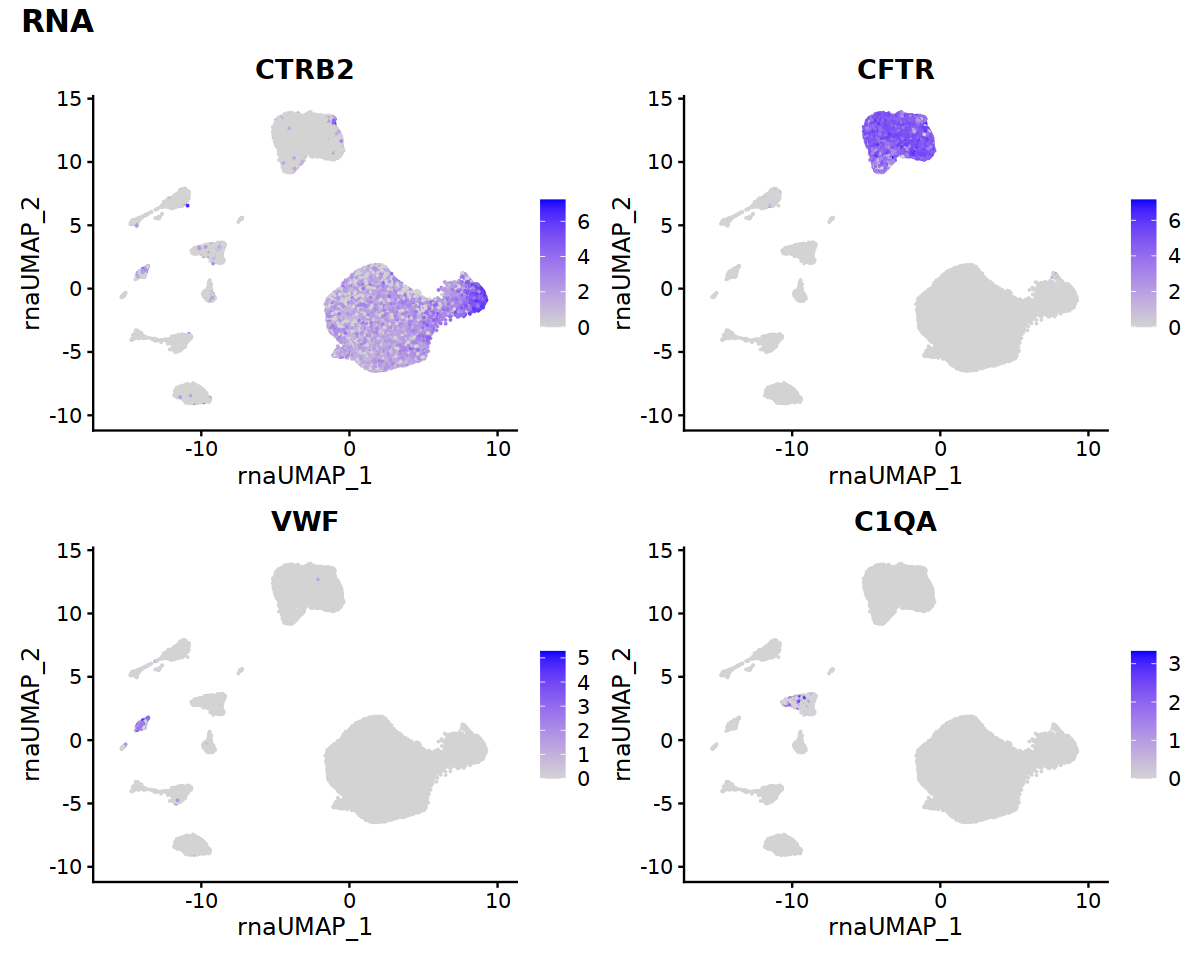

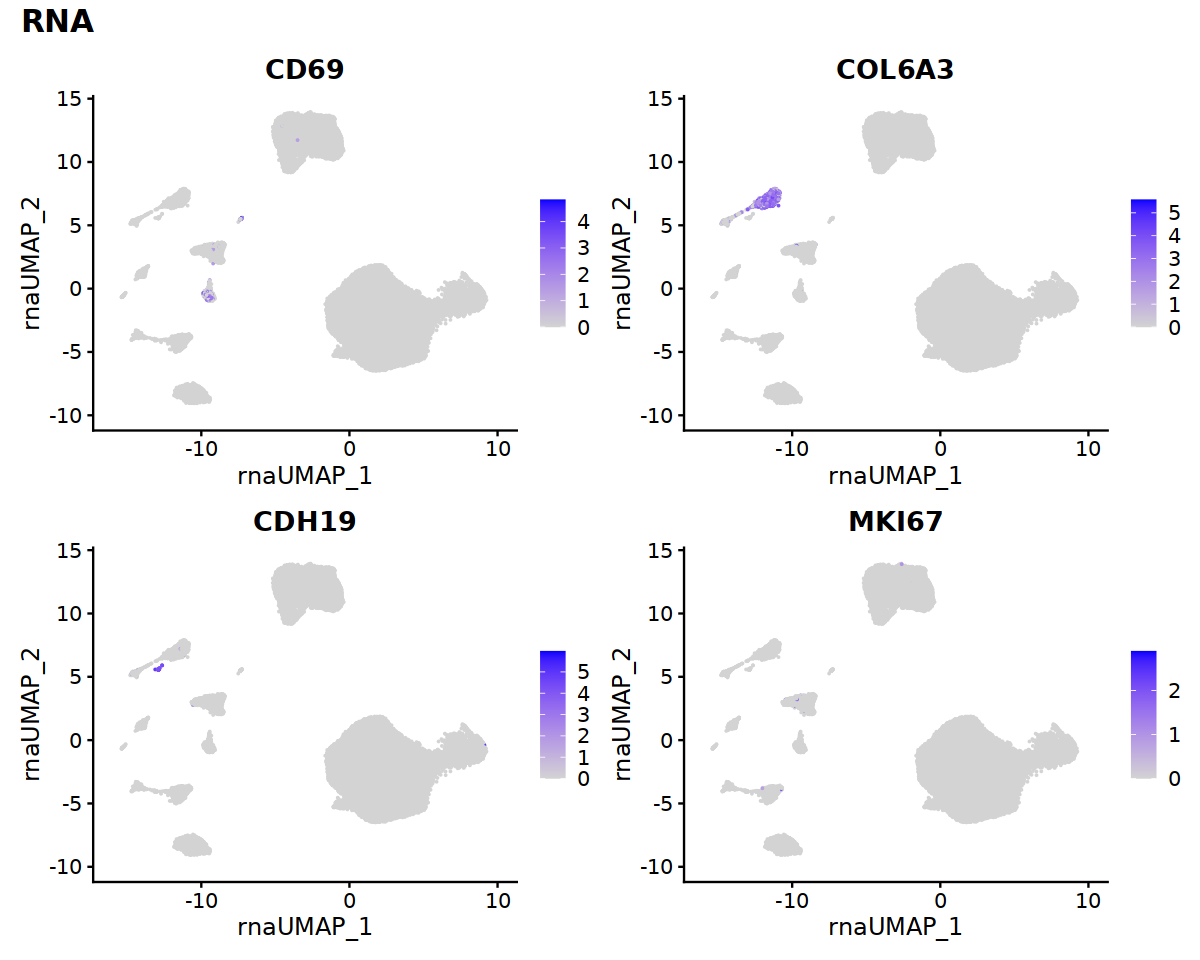

In [75]:
options(repr.plot.width=10, repr.plot.height=8)
FeaturePlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), features = c("INS", "GCG", "SST", "PPY")) + 
    patchwork::plot_annotation(title = paste0(RNA_assay), 
                               theme = theme(plot.title = element_text(size = 18, face = 'bold')))
FeaturePlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), features = c("CTRB2", "CFTR","VWF","C1QA")) + 
    patchwork::plot_annotation(title = paste0(RNA_assay), 
                               theme = theme(plot.title = element_text(size = 18, face = 'bold')))
FeaturePlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), features = c("CD69","COL6A3",'CDH19','MKI67')) + 
    patchwork::plot_annotation(title = paste0(RNA_assay), 
                               theme = theme(plot.title = element_text(size = 18, face = 'bold')))

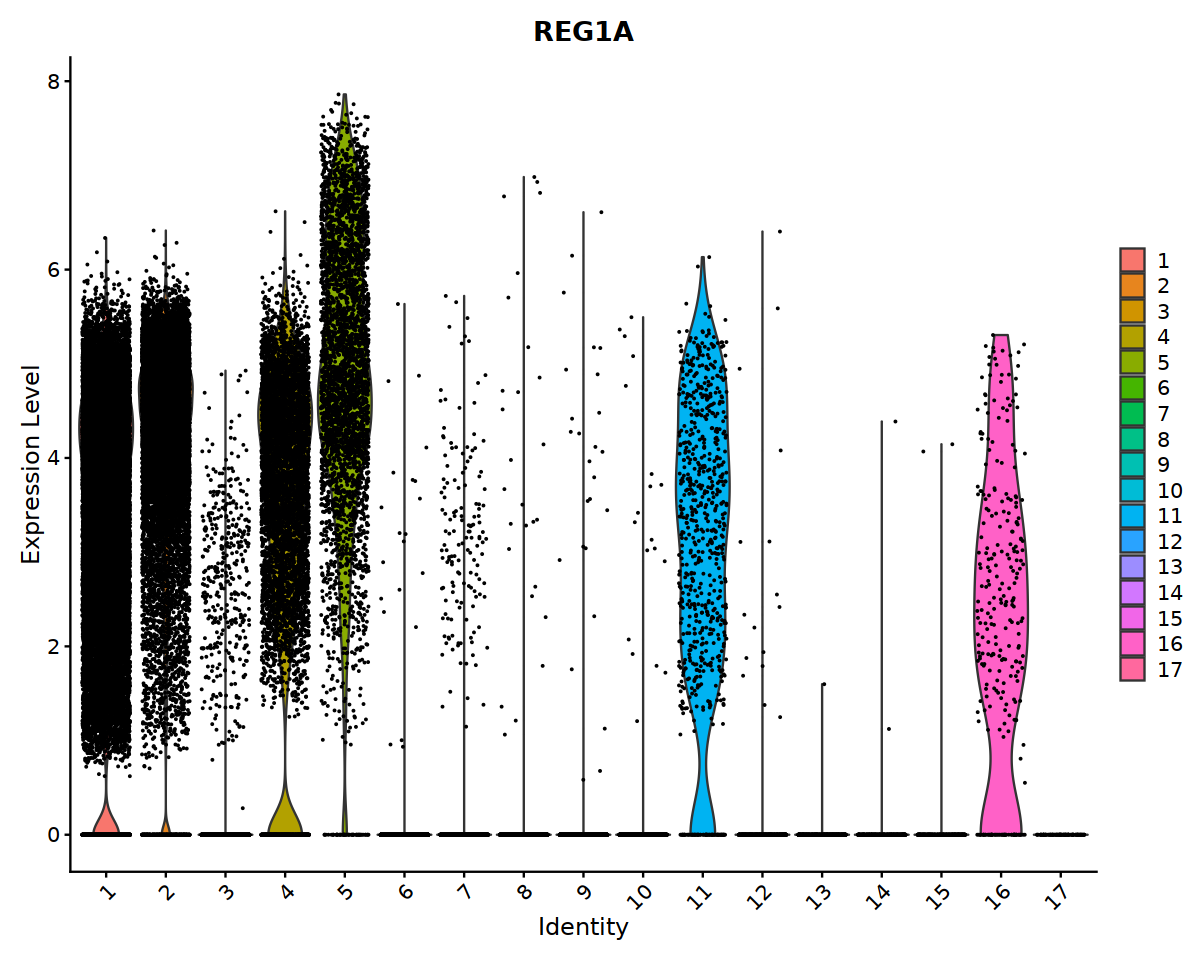

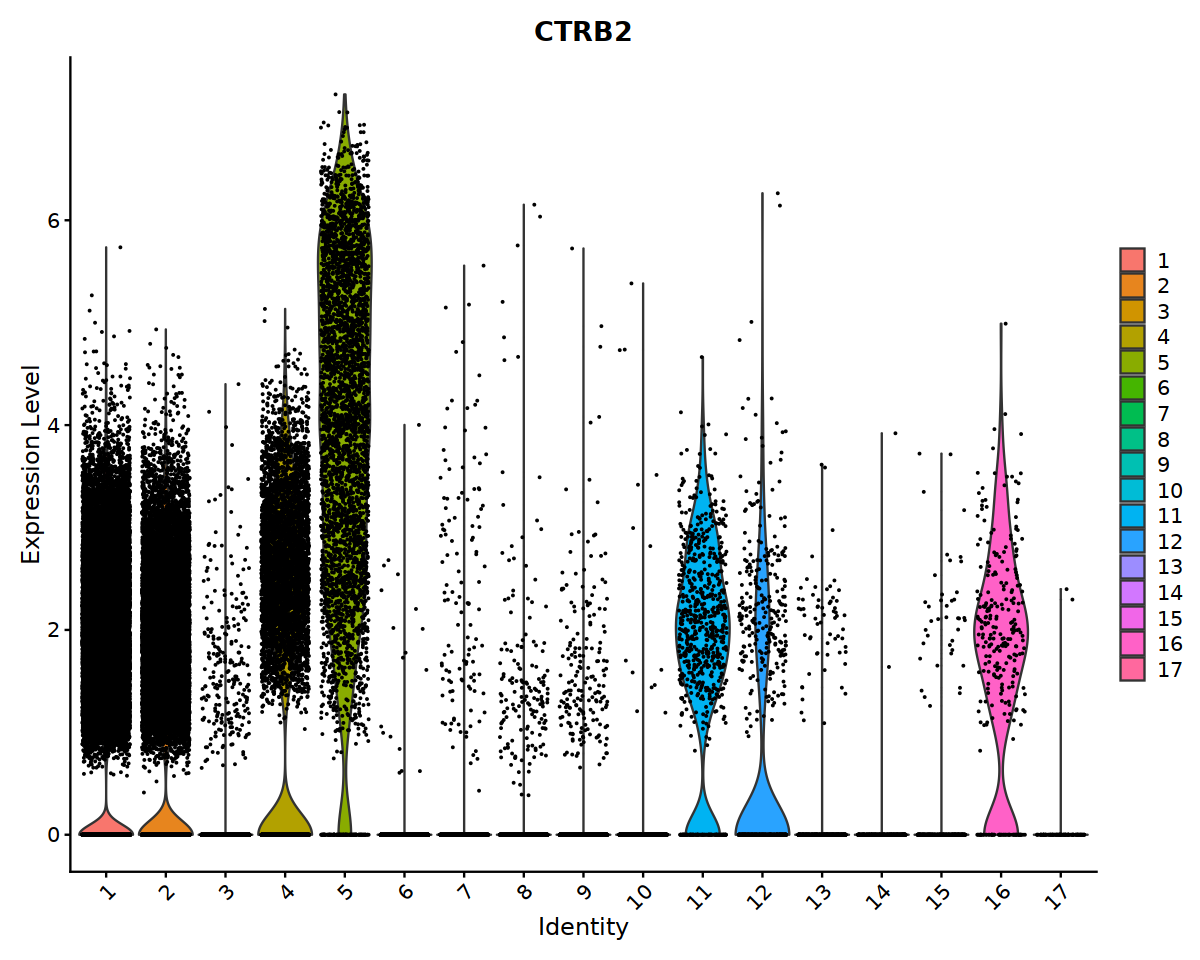

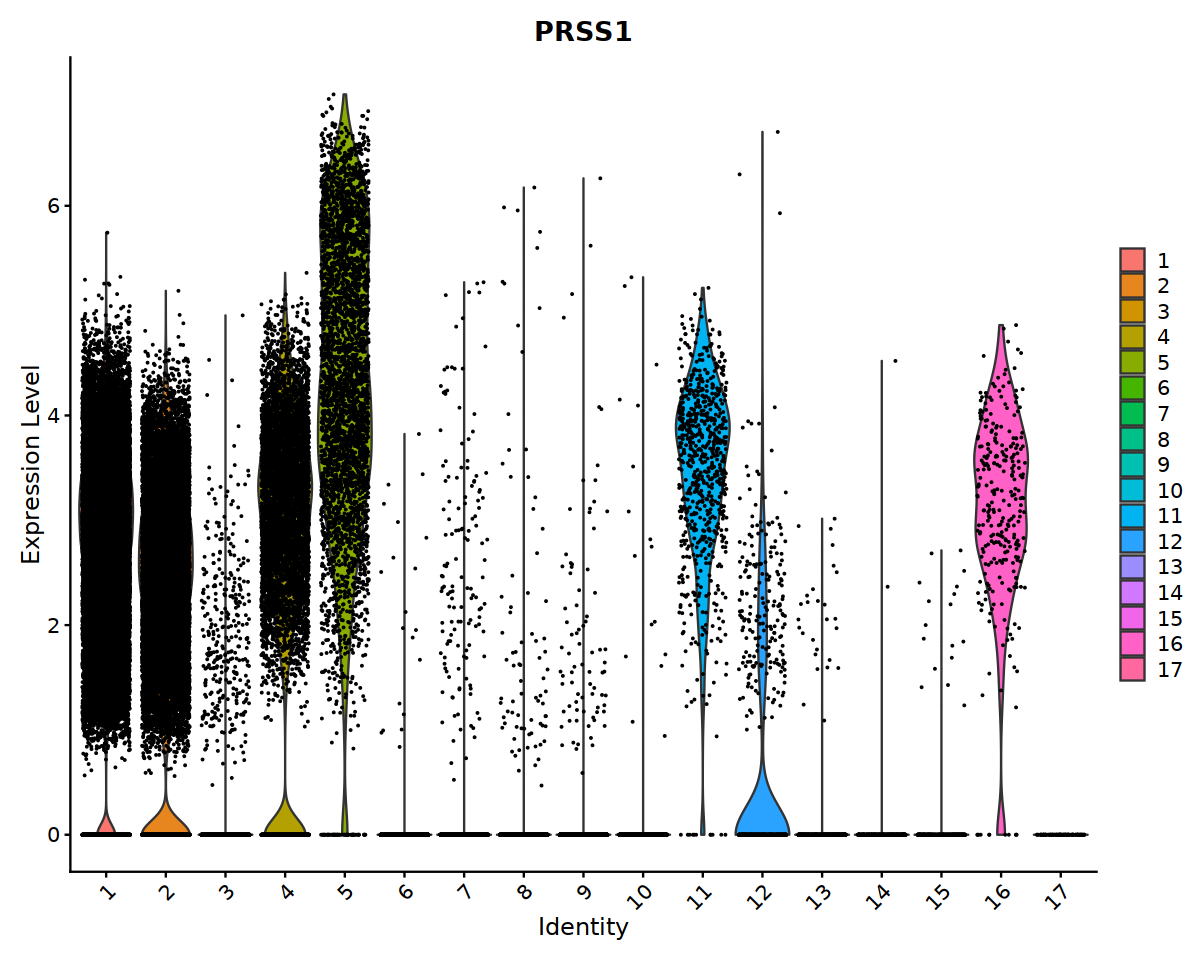

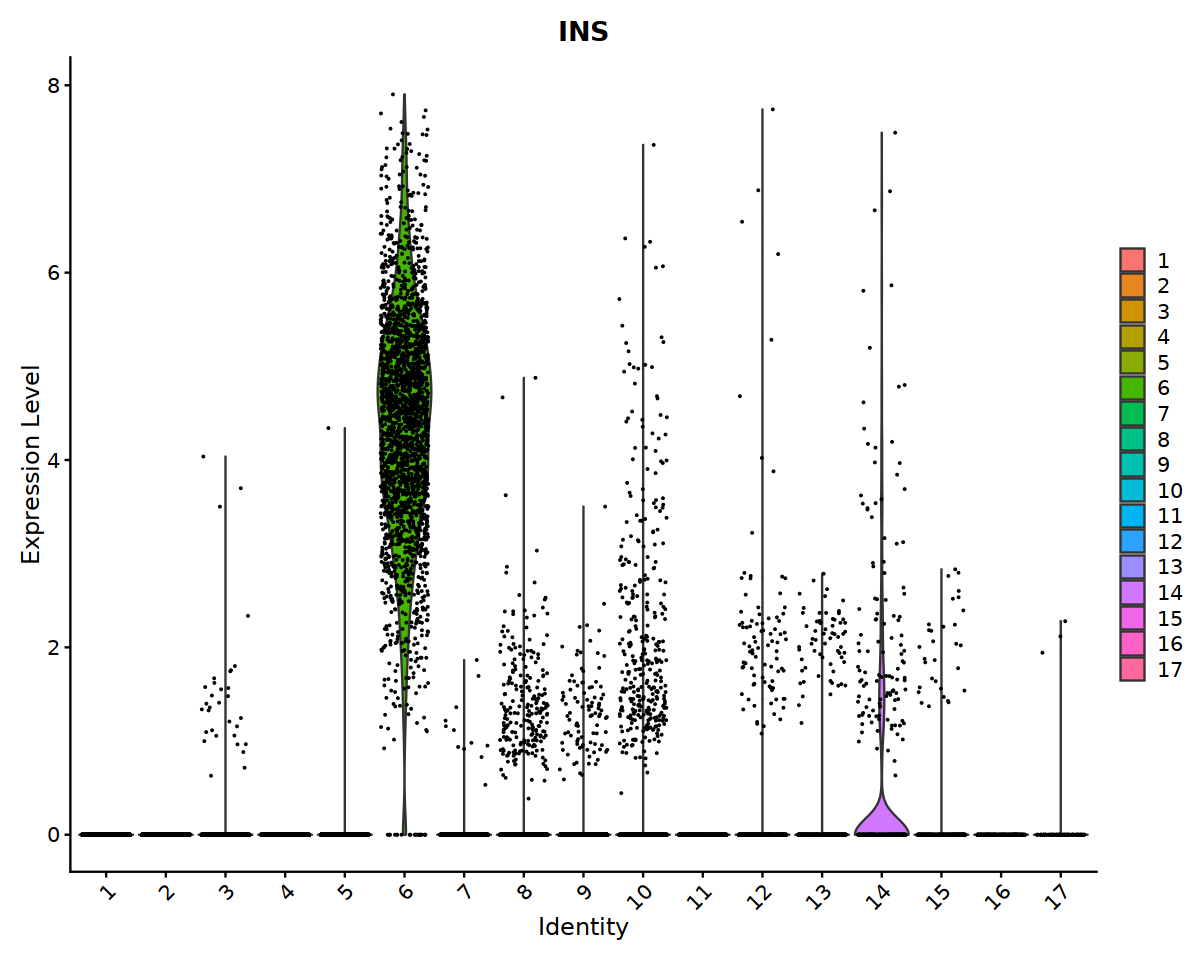

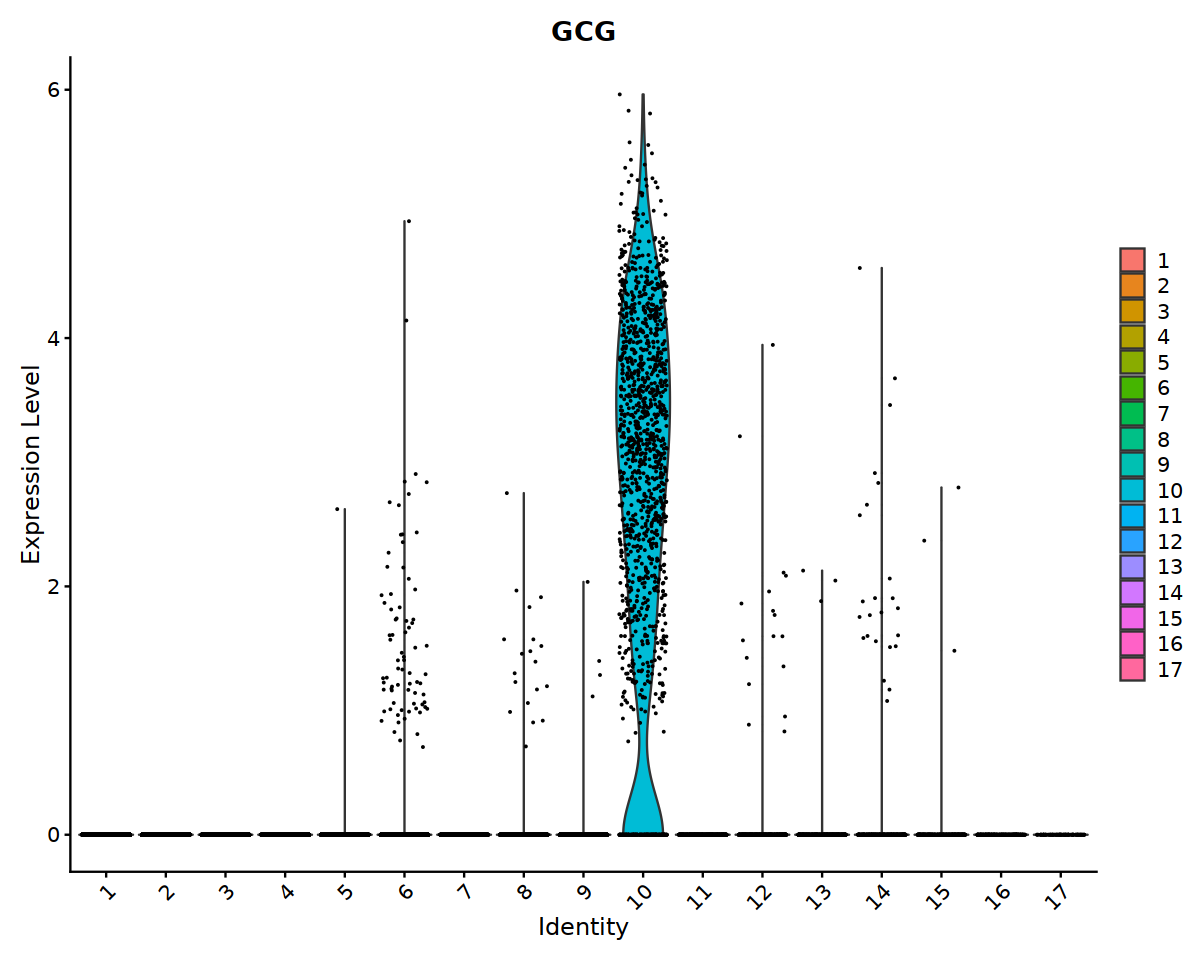

In [76]:
options(repr.plot.width=10, repr.plot.height=8)
VlnPlot(adata, features = 'REG1A') + ggtitle(paste0('REG1A'))
VlnPlot(adata, features = 'CTRB2') + ggtitle(paste0('CTRB2'))
VlnPlot(adata, features = 'PRSS1') + ggtitle(paste0('PRSS1'))
VlnPlot(adata, features = 'INS') + ggtitle(paste0('INS'))
VlnPlot(adata, features = 'GCG') + ggtitle(paste0('GCG'))

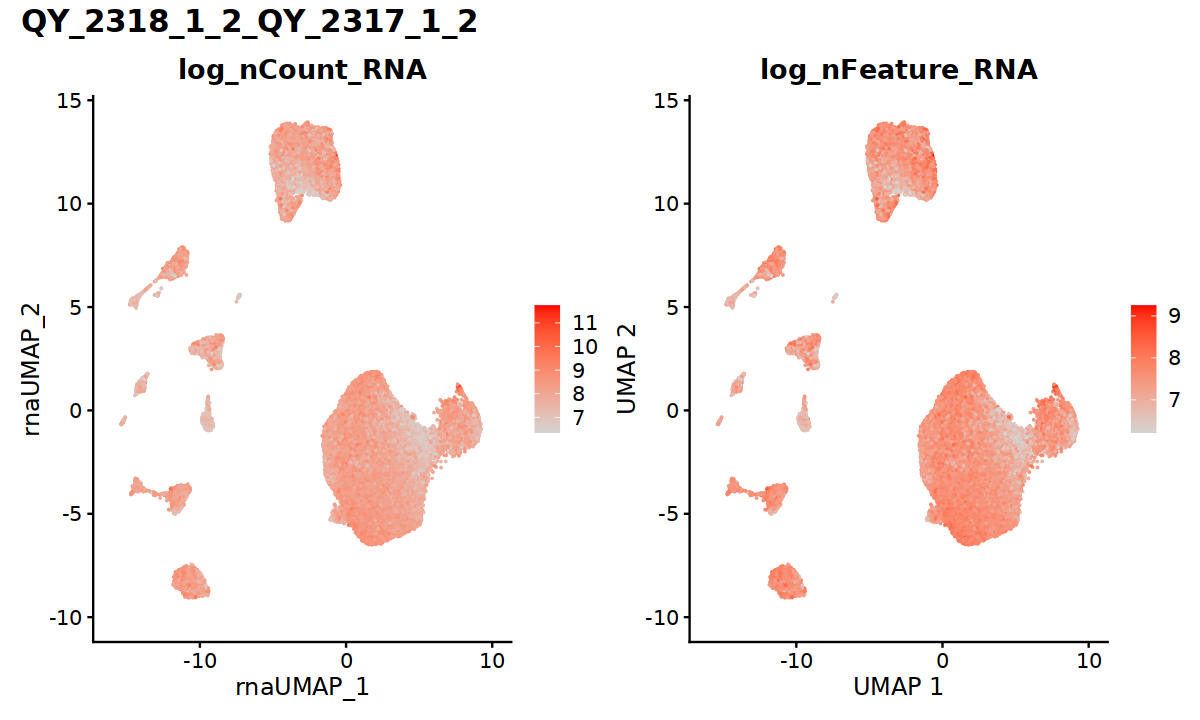

In [77]:
options(repr.plot.width=10, repr.plot.height=6)
FeaturePlot(adata, reduction=paste0('umap.', str_to_lower(RNA_assay)), features=c('log_nCount_RNA','log_nFeature_RNA'), 
                      cols=c('lightgrey', 'red'), ncol=2) + xlab('UMAP 1') + ylab('UMAP 2')  + 
        patchwork::plot_annotation(title = paste0(samp), 
                                   theme = theme(plot.title = element_text(size = 18, face = 'bold')))

In [ ]:
saveRDS(adata, paste0("/nfs/lab/welison/mega_pancreas/intermediates/Intermediate_Merge_Data/250328_AH_", dataset,"_", modality,"_hvw_window_adata_clustered.RDS"))

In [77]:
Sys.time()

[1] "2024-02-21 16:46:34 PST"

In [78]:
adata <- NULL
gc()

function (verbose = getOption("verbose"), reset = FALSE, full = TRUE) 
{
    res <- .Internal(gc(verbose, reset, full))
    res <- matrix(res, 2L, 7L, dimnames = list(c("Ncells", "Vcells"), 
        c("used", "(Mb)", "gc trigger", "(Mb)", "limit (Mb)", 
            "max used", "(Mb)")))
    if (all(is.na(res[, 5L]))) 
        res[, -5L]
    else res
}
<bytecode: 0x3c54d170>
<environment: namespace:base>

## Forgot to rewrite the sample labels 

In [ ]:
adata = readRDS("/nfs/lab/welison/mega_pancreas/intermediates/Intermediate_Merge_Data/250328_AH_nPOD_Pooled_hvw_window_adata.RDS")

In [ ]:
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "10")] <- "6433"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "11")] <- "6437"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "12")] <- "6455"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "14")] <- "6496"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "15")] <- "6538"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "16")] <- "6539"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "17")] <- "6543"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "18")] <- "6548"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "19")] <- "6553"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "20")] <- "6558"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "21")] <- "6560"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "22")] <- "6562"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "23")] <- "6569"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "24")] <- "CV02"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6301")] <- "6301"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6303")] <- "6303"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6314")] <- "6314"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6347")] <- "6347"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6392")] <- "6392"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6397")] <- "6397"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6400")] <- "6400"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6424")] <- "6424"
adata@meta.data$donor_demux[which(adata@meta.data$donor_demux == "nPOD-6483")] <- "6483"

In [ ]:
adata@meta.data$donor_demux 

In [ ]:
saveRDS(adata, paste0("/nfs/lab/welison/mega_pancreas/intermediates/Intermediate_Merge_Data/250328_AH_nPOD_Pooled_hvw_window_adata_renamed.RDS"))

In [112]:
#check and make sure there is both an RNA and ATAC assay
adata = readRDS("/nfs/lab/welison/mega_pancreas/intermediates/Intermediate_Merge_Data/250328_AH_nPOD_Pooled_hvw_window_adata_renamed.RDS")

In [113]:
adata@assays

$ATAC
ChromatinAssay data with 230223 features for 78799 cells
Variable features: 0 
Genome: 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 8 

$RNA
Assay data with 36601 features for 78799 cells
First 10 features:
 MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2,
AL627309.5, AL627309.4, AP006222.2, AL732372.1 
